In [1]:
import pandas as pd
import numpy as np
import json

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.linalg import norm

# local library
from preproc import *

In [2]:
sw = set(stopwords.words('english') + ["[applause]", "[music]"] \
    + ["that's", "they'll", "they're", "we'll", "we're", "i'm", "i'll", "they've",
 "i've", "here's", "it'll", "we've", "let's", "he's", "there's", "i'd", "what's"])

In [3]:
with open('speeches.json') as f:
    speeches = json.load(f)

In [4]:
bow = create_bow(speeches)
bow

index speaker                  date  \
id                                                 
oWlLZZ8pcp8      8   trump  2019-04-28T02:07:41Z   
Z6N1WdJgnLo     47   biden  2019-04-29T21:04:46Z   
WIwGrZKdsY0      9   trump  2019-05-09T03:55:17Z   
u-AEAq7jzcU     48   biden  2019-05-18T19:53:18Z   
GgINUxecNrg     10   trump  2019-05-21T00:39:36Z   
...            ...     ...                   ...   
4lGvJJKfekk    166   biden  2020-10-24T19:04:05Z   
RzKt6YTnbuk    168   trump  2020-10-25T04:40:11Z   
KrI1V281Wl4    169   pence  2020-10-25T10:24:34Z   
8fjmmw7TNPY    171   biden  2020-10-26T07:19:29Z   
qJVhGXSZO9Y    170   trump  2020-10-26T13:00:10Z   

                                                        speech  \
id                                                               
oWlLZZ8pcp8  [Music] [Music] [Music] [Music] [Music] [Appla...   
Z6N1WdJgnLo  [Applause] [Music] my name [Applause] thank yo...   
WIwGrZKdsY0  [Music] from the leaves of Minnesota [Music] a...   
u-AEAq7jzcU  so let's do this please welcome my husband Joe...   
GgINUxecNrg  [Music] from the laser Minnesota [Music] the T...   
...                                                        ...   
4lGvJJKfekk  today a lot of things have happened today okay...   
RzKt6YTnbuk  from the lakes of minnesota to the hills of te...   
KrI1V281Wl4  from the lakes of minnesota to the hills of te...   
8fjmmw7TNPY  let's just start with the endorsement i mean y...   
qJVhGXSZO9Y  [Music] [Applause] [Music] [Applause] [Music] ...   

                                                         title transcript_type  
id                                                                              
oWlLZZ8pcp8  Watch Live: President Trump's MAGA Rally in Gr...          speech  
Z6N1WdJgnLo          Joe Biden holds first 2020 campaign rally          speech  
WIwGrZKdsY0  FULL RALLY: President Trump in Panama City Bea...          speech  
u-AEAq7jzcU  Joe Biden speaks during a campaign rally in Ph...          speech  
GgINUxecNrg  FULL RALLY: President Trump in Montoursville, ...          speech  
...                                                        ...             ...  
4lGvJJKfekk  Reaction to Hunter Biden’s Business Partner Sp...          speech  
RzKt6YTnbuk  President Donald Trump FULL SPEECH at Circlevi...          speech  
KrI1V281Wl4  FULL LIVE EVENT Vice President Mike Pence Lake...          speech  
8fjmmw7TNPY  Talk Time 🔴 Watch Joe Biden’s Full Interview W...       interview  
qJVhGXSZO9Y  Donald and Melania Trump: A Love Story for the...          speech  

[172 rows x 6 columns]

In [5]:
#bow[['speaker','date','title','transcript_type','speech']].to_csv('data/speeches.csv')

In [17]:
import string
import re
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.snowball import SnowballStemmer

def my_tokenizer(document):
        #tk = WhitespaceTokenizer()
        stemmer = SnowballStemmer("english")
        # Break the sentence into tokens based on whitespace
        for token in document.split():
            # Apply preprocessing to the token
            token = token.lower().strip()
            token = re.sub(r'[_*:!?& ]', '', token).rstrip('.,')

            # If punctuation, ignore token and continue
            if all(char in set(string.punctuation) for char in token):
                continue
                
            # if empty str, continue
            if token == '':
                continue
                
            # skip stopwords
            if token in sw:
                continue

            # stem the token and yield
            stem = stemmer.stem(token)
            yield token

In [18]:
# testing. no better than nltk out of the box
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import re

nlp = nlp = English(disable=['ner','parser','tagger']) # , disable=['ner','parser','tagger']

def spacy_tokenize(text):
    text = text.lower().replace('[applause]','').replace('[music]','')
    tokens = [x.text for x in nlp(text)]
    tokens = [re.sub(r'[_*:!?& ]', '', tok) for tok in tokens]
    tokens = [tok for tok in tokens if tok != '']
    return tokens
    #text.lower().strip().strip('_').strip('*')

# Combined 1,2,3 grams

In [27]:
# 

vectorizer = CountVectorizer(max_features=5000, # only top 5k words
                             min_df=2,          # words must appear in this many speeches to count
                             #max_df=0.9,        # words can't appear in more % of speeches than this.  
                             stop_words=stopwords.words('english'),
                             tokenizer=my_tokenizer,
                             ngram_range=(1,1)  # (1,3) combined unigrams, bigrams, trigrams
                            )

counts = vectorizer.fit_transform(bow['speech'])

In [28]:
counts_df = pd.DataFrame(counts.toarray())
counts_df.index.name = 'speech'
#tfidf.columns = tfidf.apply(lambda x: vocab_r[x.name])
counts_df.columns = vectorizer.get_feature_names()

In [29]:
counts_df.head(3)

$10,000  (applause)  000  1  1%  1.5  1.6  1.8  10  10%  ...  younger  \
speech                                                           ...            
0             0           0    0  0   0    0    0    1   1    0  ...        0   
1             0           0    0  0   0    0    0    0   0    0  ...        0   
2             0           0    0  1   1    0    0    0   4    0  ...        0   

        youngest  youth  youtube  zero  zip  zone  zones  zoom  ♪  
speech                                                             
0              0      1        0     2    0     0      1     0  0  
1              0      0        0     0    0     0      0     0  0  
2              0      0        0     0    0     0      0     0  0  

[3 rows x 5000 columns]

In [30]:
# convert counts into tfidf
transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(counts)

In [31]:
tfidf_df = pd.DataFrame(tfidf.toarray())
tfidf_df.index.name = 'speech'
tfidf_df.columns = vectorizer.get_feature_names()
tfidf_df['videoId'] = bow.index.values
tfidf_df = tfidf_df.set_index('videoId')

In [33]:
tfidf_df['_speaker'] = tfidf_df.apply(lambda x: bow.loc[x.name].speaker, 1)
tfidf_df = tfidf_df.reset_index().set_index(['videoId','_speaker'])

In [34]:
tfidf_df.head()

$10,000  (applause)  000         1        1%  1.5  1.6  \
videoId     _speaker                                                           
oWlLZZ8pcp8 trump         0.0         0.0  0.0  0.000000  0.000000  0.0  0.0   
Z6N1WdJgnLo biden         0.0         0.0  0.0  0.000000  0.000000  0.0  0.0   
WIwGrZKdsY0 trump         0.0         0.0  0.0  0.007626  0.011493  0.0  0.0   
u-AEAq7jzcU biden         0.0         0.0  0.0  0.000000  0.000000  0.0  0.0   
GgINUxecNrg trump         0.0         0.0  0.0  0.020538  0.015476  0.0  0.0   

                           1.8        10       10%  ...  younger  youngest  \
videoId     _speaker                                ...                      
oWlLZZ8pcp8 trump     0.010493  0.004879  0.000000  ...      0.0       0.0   
Z6N1WdJgnLo biden     0.000000  0.000000  0.000000  ...      0.0       0.0   
WIwGrZKdsY0 trump     0.000000  0.017054  0.000000  ...      0.0       0.0   
u-AEAq7jzcU biden     0.000000  0.010501  0.000000  ...      0.0       0.0   
GgINUxecNrg trump     0.000000  0.000000  0.016461  ...      0.0       0.0   

                         youth  youtube      zero  zip  zone     zones  zoom  \
videoId     _speaker                                                           
oWlLZZ8pcp8 trump     0.010664      0.0  0.014624  0.0   0.0  0.008445   0.0   
Z6N1WdJgnLo biden     0.000000      0.0  0.000000  0.0   0.0  0.000000   0.0   
WIwGrZKdsY0 trump     0.000000      0.0  0.000000  0.0   0.0  0.000000   0.0   
u-AEAq7jzcU biden     0.000000      0.0  0.000000  0.0   0.0  0.000000   0.0   
GgINUxecNrg trump     0.000000      0.0  0.000000  0.0   0.0  0.000000   0.0   

                        ♪  
videoId     _speaker       
oWlLZZ8pcp8 trump     0.0  
Z6N1WdJgnLo biden     0.0  
WIwGrZKdsY0 trump     0.0  
u-AEAq7jzcU biden     0.0  
GgINUxecNrg trump     0.0  

[5 rows x 5000 columns]

In [99]:
# collapse to speaker-only
tfidf_speaker = tfidf_df.reset_index().drop(columns="videoId").groupby(['_speaker']).mean()
# Normalize doc vector lengths
tfidf_speaker = tfidf_speaker.apply(lambda x: x / norm(x), 1)
# transpose for easier filtering
tfidf_speaker = tfidf_speaker.T.reset_index()

In [100]:
tfidf_speaker.sort_values('biden', ascending=False).head(10)#[['index']].values

_speaker      index     biden    harris     pence     trump
2278           know  0.208280  0.242533  0.140335  0.257837
3323      president  0.196802  0.119059  0.349722  0.114591
3170         people  0.179366  0.177081  0.080696  0.202203
1740          going  0.174345  0.093455  0.116853  0.172811
2451           like  0.149356  0.249279  0.047812  0.165026
1686            get  0.148178  0.110462  0.023441  0.116853
4522          trump  0.140494  0.103819  0.196248  0.067371
3020            one  0.139142  0.119123  0.073671  0.141360
4579             uh  0.130603  0.140087  0.021307  0.081168
4637             us  0.124190  0.108960  0.042675  0.081601

In [101]:
# alternate method of speaker-only TFIDF
# collapse speech-level counts first
counts_df['videoId'] = bow.index.values
counts_df = counts_df.set_index('videoId')
counts_df['_speaker'] = counts_df.apply(lambda x: bow.loc[x.name].speaker, 1)
counts_df = counts_df.reset_index().set_index(['_speaker']).drop(columns=['videoId'])


In [102]:
# convert counts into tfidf
transformer = TfidfTransformer(smooth_idf=True)
tfidf_speaker2 = transformer.fit_transform(counts_df.sum(level='_speaker'))
tfidf_speaker2 = pd.DataFrame(tfidf_speaker2.toarray())
tfidf_speaker2.columns = vectorizer.get_feature_names()
tfidf_speaker2['_speaker'] = counts_df.sum(level='_speaker').index.values
tfidf_speaker2 = tfidf_speaker2.set_index('_speaker')
tfidf_speaker2.index.name = 'speaker'
# Normalize doc vector lengths
#tfidf_speaker2 = tfidf_speaker2.apply(lambda x: x / norm(x), 1)
# transpose for easier filtering
tfidf_speaker2 = tfidf_speaker2.T.reset_index()

In [103]:
tfidf_speaker2.loc[~tfidf_speaker2['index'].isin(stopwords.words('english'))].sort_values('biden', ascending=False).head(10)#\
    #.reset_index()[['index']].values

speaker      index     trump     biden    harris     pence
2278          know  0.322709  0.304774  0.391039  0.203782
2451          like  0.230380  0.300739  0.488900  0.067373
1740         going  0.202824  0.210356  0.143123  0.181325
4579            uh  0.051914  0.199327  0.192869  0.023289
3170        people  0.239565  0.197982  0.190015  0.121438
1686           get  0.137235  0.184532  0.136598  0.034518
3020           one  0.164178  0.179421  0.144346  0.097316
3653         right  0.175337  0.167586  0.143123  0.088167
3323     president  0.113829  0.159247  0.075435  0.415050
4368         think  0.117912  0.148218  0.119473  0.066957

In [104]:
# compare to speech-collapsed-into-speaker
tfidf_speaker.sort_values('biden', ascending=False).head(10)#[['index']].values

_speaker      index     biden    harris     pence     trump
2278           know  0.208280  0.242533  0.140335  0.257837
3323      president  0.196802  0.119059  0.349722  0.114591
3170         people  0.179366  0.177081  0.080696  0.202203
1740          going  0.174345  0.093455  0.116853  0.172811
2451           like  0.149356  0.249279  0.047812  0.165026
1686            get  0.148178  0.110462  0.023441  0.116853
4522          trump  0.140494  0.103819  0.196248  0.067371
3020            one  0.139142  0.119123  0.073671  0.141360
4579             uh  0.130603  0.140087  0.021307  0.081168
4637             us  0.124190  0.108960  0.042675  0.081601

In [17]:
top10 = pd.DataFrame(tfidf_speaker.sort_values('biden', ascending=False).head(10)[['index']].values)
top10.columns = ['biden']
top10['trump'] = tfidf_speaker.sort_values('trump', ascending=False).head(10)[['index']].values
top10['harris'] = tfidf_speaker.sort_values('harris', ascending=False).head(10)[['index']].values
top10['pence'] = tfidf_speaker.sort_values('pence', ascending=False).head(10)[['index']].values
top10

biden   trump           harris                   pence
0       know    know             like               president
1  president  people             know  president donald trump
2     people    said               um        president donald
3      going   great           people                   trump
4       like   going               uh                   years
5         uh    like            would                 america
6        get    want            right                    know
7        one   right              one            donald trump
8      trump     one  affordable care                  donald
9         us   thank             yeah                american

In [18]:
tfidf_speaker['avg'] = np.mean(tfidf_speaker, axis=1)

In [19]:
tfidf_speaker.columns

Index(['index', 'biden', 'harris', 'pence', 'trump', 'avg'], dtype='object', name='_speaker')

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(tfidf_short)
csdf = pd.DataFrame(data=cs, index=['biden','harris','pence','trump'], columns=['biden','harris','pence','trump'])

In [23]:
csdf

biden    harris     pence     trump
biden   1.000000  0.770182  0.591001  0.812160
harris  0.770182  1.000000  0.478395  0.734717
pence   0.591001  0.478395  1.000000  0.595842
trump   0.812160  0.734717  0.595842  1.000000

In [16]:
# let's look at cosine similarity for all the speeches
from sklearn.metrics.pairwise import cosine_similarity
tfidf_df_mean = tfidf_df.mean()
tfidf_a = tfidf_df.T
tfidf_a['avg'] = tfidf_df_mean
all_sp = tfidf_a.sort_values(['avg'], ascending=False)\
    .drop(columns=['avg'])\
    .head(30000).T

csa = cosine_similarity(all_sp)
csadf = pd.DataFrame(data=csa, index=bow.index, columns=bow.index)

In [17]:
csadf

id           oWlLZZ8pcp8  Z6N1WdJgnLo  WIwGrZKdsY0  u-AEAq7jzcU  GgINUxecNrg  \
id                                                                             
oWlLZZ8pcp8     1.000000     0.424373     0.763841     0.409552     0.681015   
Z6N1WdJgnLo     0.424373     1.000000     0.458000     0.493844     0.448534   
WIwGrZKdsY0     0.763841     0.458000     1.000000     0.460827     0.688681   
u-AEAq7jzcU     0.409552     0.493844     0.460827     1.000000     0.437212   
GgINUxecNrg     0.681015     0.448534     0.688681     0.437212     1.000000   
...                  ...          ...          ...          ...          ...   
3NUl7qoedtw     0.436982     0.427140     0.468476     0.458098     0.451681   
VF6kAXnRMLs     0.309612     0.330769     0.331223     0.356430     0.303675   
eGhM2w3Wt_M     0.325384     0.306363     0.360635     0.348511     0.346627   
BmSSNWScR_c     0.615758     0.373197     0.633390     0.388029     0.561921   
4lGvJJKfekk     0.331617     0.258014     0.350351     0.281364     0.309462   

id           S7j1hYXD0uk  yE2sMLutWZA  MEqINP-TuV8  xH-iCVFTb6w  Vd65smKGDVo  \
id                                                                             
oWlLZZ8pcp8     0.282231     0.267768     0.677255     0.280649     0.219133   
Z6N1WdJgnLo     0.275262     0.199437     0.416777     0.204535     0.181064   
WIwGrZKdsY0     0.272893     0.245406     0.679570     0.307138     0.204337   
u-AEAq7jzcU     0.261972     0.293186     0.440069     0.279091     0.258455   
GgINUxecNrg     0.283652     0.294626     0.680670     0.278249     0.244923   
...                  ...          ...          ...          ...          ...   
3NUl7qoedtw     0.275932     0.241769     0.416715     0.207450     0.211101   
VF6kAXnRMLs     0.228508     0.252255     0.317140     0.192284     0.227229   
eGhM2w3Wt_M     0.227342     0.214445     0.331874     0.214678     0.183397   
BmSSNWScR_c     0.239727     0.239868     0.557834     0.282894     0.294272   
4lGvJJKfekk     0.146677     0.134015     0.303583     0.140820     0.113415   

id           ...  X_GInHCSOEc  W6QWULSog5I  qFmTXoNnUks  HNJ1n0nBb8k  \
id           ...                                                       
oWlLZZ8pcp8  ...     0.356677     0.436982     0.435281     0.401092   
Z6N1WdJgnLo  ...     0.266301     0.427140     0.298895     0.293774   
WIwGrZKdsY0  ...     0.339755     0.468476     0.474096     0.390889   
u-AEAq7jzcU  ...     0.348476     0.458098     0.311049     0.351984   
GgINUxecNrg  ...     0.364739     0.451681     0.425435     0.400648   
...          ...          ...          ...          ...          ...   
3NUl7qoedtw  ...     0.412797     1.000000     0.369231     0.430031   
VF6kAXnRMLs  ...     0.316609     0.392129     0.263775     0.327335   
eGhM2w3Wt_M  ...     0.360854     0.478830     0.255371     0.370304   
BmSSNWScR_c  ...     0.361609     0.447937     0.456285     0.399606   
4lGvJJKfekk  ...     0.275437     0.324893     0.463009     0.290473   

id           Xwx_9f1zxjk  3NUl7qoedtw  VF6kAXnRMLs  eGhM2w3Wt_M  BmSSNWScR_c  \
id                                                                             
oWlLZZ8pcp8     0.403666     0.436982     0.309612     0.325384     0.615758   
Z6N1WdJgnLo     0.293766     0.427140     0.330769     0.306363     0.373197   
WIwGrZKdsY0     0.394805     0.468476     0.331223     0.360635     0.633390   
u-AEAq7jzcU     0.354150     0.458098     0.356430     0.348511     0.388029   
GgINUxecNrg     0.407576     0.451681     0.303675     0.346627     0.561921   
...                  ...          ...          ...          ...          ...   
3NUl7qoedtw     0.437432     1.000000     0.392129     0.478830     0.447937   
VF6kAXnRMLs     0.321085     0.392129     1.000000     0.296893     0.311038   
eGhM2w3Wt_M     0.387622     0.478830     0.296893     1.000000     0.350197   
BmSSNWScR_c     0.399930     0.447937     0.311038     0.350197     1.000000   
4lGvJJKfekk     0.294

In [18]:
csadf.to_csv('speech_similarity.csv')

## Hierarchical Cluster Analysis and Dendrograms

In [37]:
import scipy.cluster.hierarchy as sch
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(10, 30)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = bow.speaker.values 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 432x288 with 0 Axes>

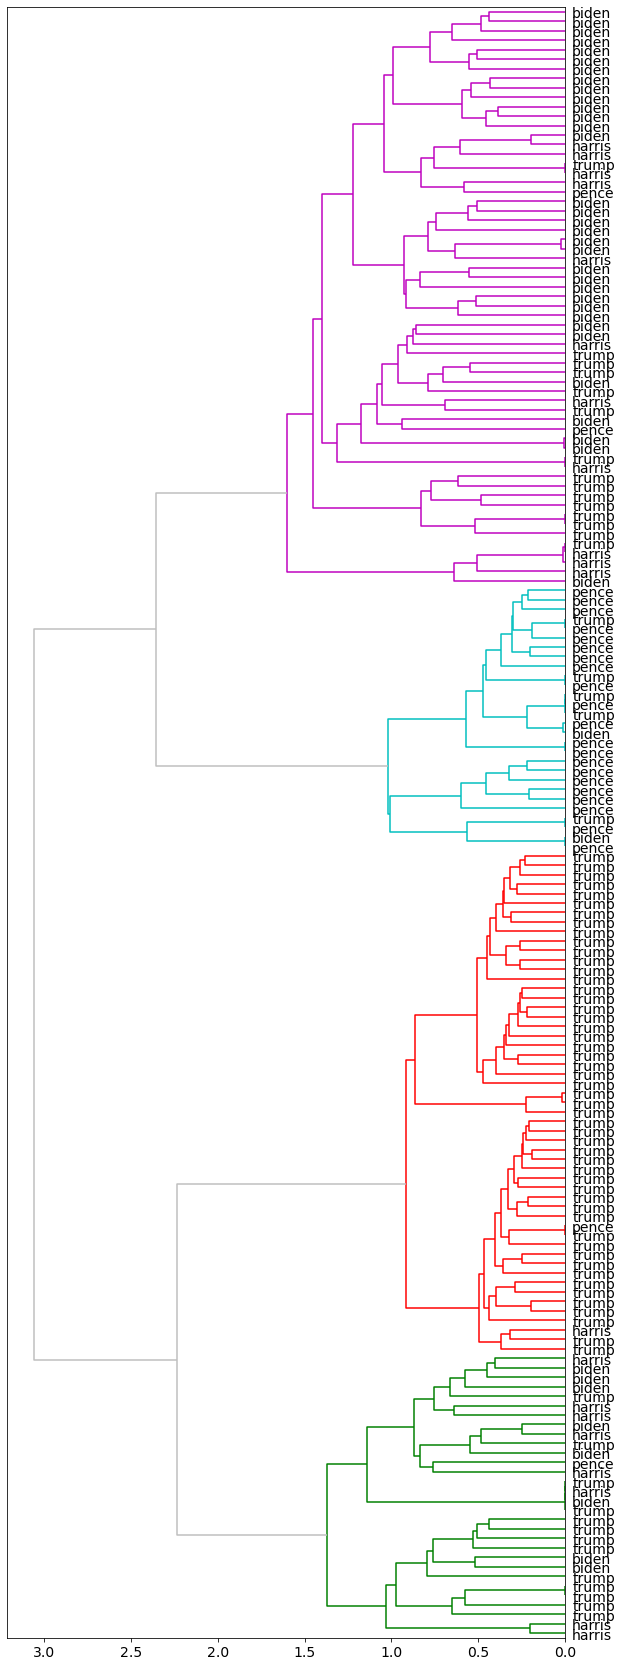

In [39]:
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt

all_sp = tfidf_df
L1 = all_sp.apply(lambda x: x / x.sum(), 1)

PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([bow.index.tolist(), bow.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['speech_a', 'speech_b']

PAIRS['cosine'] = pdist(L1, 'cosine')
PAIRS['cityblock'] = pdist(L1, 'cityblock')

hca(PAIRS['cosine'], color_thresh=2)
#hca(PAIRS['cityblock'], color_thresh=4.6)

### Group 0 (red): Trump rallies
1 speech labeled "harris", actually titled "Trump blasts Joe Biden, mocks Kamala Harris at.." bxuykoOlwjA
1 "pence" speech, but the first 1.5 hours are random crowd talking, followed by a short Pence speech

### Group 1 (purple): Formal, "presidential" speeches
33/61 speeches Biden
15 trump, 11 harris, 2 pence
Interestingly, these Trump speeches are not rallies, but major public appearances - SOTU, RNC, 4th of July, 60 minutes, etc.

### Group 2 (blue): Pence speeches (21/26)
1 "biden" actually Pence

### Group 3 (green): Casual talk
7 interviews, a couple press conferences, several miscategorized talk shows

In [52]:
tree = sch.linkage(PAIRS['cosine'], method='ward')
cuts = sch.cut_tree(tree, height=2)
bow['group'] = cuts
bow['date'] = pd.to_datetime(bow['date'])

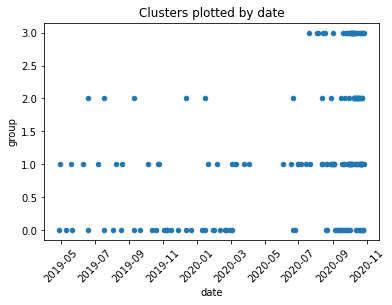

In [96]:
ax = bow.sort_values(['date']).reset_index().plot.scatter('date','group')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Clusters plotted by date')
plt.show()

In [92]:
bow[bow['group']==3][['speaker','date']].groupby('speaker').count()

date
speaker      
biden       8
harris      8
pence       1
trump      13

In [98]:
bow[bow['group']==3].sort_values(['speaker'])[['speaker','date','title','transcript_type']].head(30)

speaker                      date  \
id                                              
8fjmmw7TNPY   biden 2020-10-26 07:19:29+00:00   
dx1PDSKMl6s   biden 2020-10-19 16:00:30+00:00   
I-8BtQg6F2A   biden 2020-10-17 16:16:42+00:00   
0uvbOXfFEi8   biden 2020-10-13 03:05:59+00:00   
8gvkshtY1kk   biden 2020-09-25 16:37:24+00:00   
w1q10K8Cmic   biden 2020-09-30 02:57:05+00:00   
NKbhNPHxGdI   biden 2020-10-06 20:58:17+00:00   
4lGvJJKfekk   biden 2020-10-24 19:04:05+00:00   
tes38JVOLM0  harris 2020-10-21 01:47:37+00:00   
7Ol3RSIykPc  harris 2020-10-12 12:00:11+00:00   
K39Emjp4wJ0  harris 2020-10-10 02:48:25+00:00   
OR7aIiZgkSU  harris 2020-10-09 12:00:11+00:00   
sNzvRHEU4P0  harris 2020-10-08 18:36:41+00:00   
LADHrlBeygs  harris 2020-10-04 23:43:20+00:00   
75QgFPgSySA  harris 2020-10-02 03:57:12+00:00   
A9D_RLWyxZU  harris 2020-10-04 07:17:42+00:00   
WX1wwgm9GZ0   pence 2020-10-02 19:58:52+00:00   
AvbHCvg2DS4   trump 2020-10-05 19:39:35+00:00   
sKCkM-f2Qk4   trump 2020-10-06 03:16:46+00:00   
yortSGqDpIc   trump 2020-10-07 01:21:31+00:00   
6Zg1ij9NtUM   trump 2020-09-28 20:11:10+00:00   
-bHGb17kejM   trump 2020-09-23 22:54:43+00:00   
AZ1tNqhazlE   trump 2020-09-18 19:47:02+00:00   
lLsae1X4gx4   trump 2020-09-01 19:54:33+00:00   
IOJSI0Zfjcc   trump 2020-08-17 19:56:13+00:00   
XuljlCg7g98   trump 2020-08-13 13:30:08+00:00   
LAu-Sq8oegs   trump 2020-08-04 22:46:52+00:00   
zaaTZkqsaxY   trump 2020-08-04 03:57:59+00:00   
qFmTXoNnUks   trump 2020-10-22 17:23:25+00:00   
W6XdpDOH1JA   trump 2020-07-19 19:30:10+00:00   

                                                         title transcript_type  
id                                                                              
8fjmmw7TNPY  Talk Time 🔴 Watch Joe Biden’s Full Interview W...       interview  
dx1PDSKMl6s  Noam Chomsky / Bad Faith Debate on Voting for ...          speech  
I-8BtQg6F2A  War Room: Pandemic Ep 443 -The CCP's Ownership...          speech  
0uvbOXfFEi8  Joe Biden's Body Language - Interview About Ta...       interview  
8gvkshtY1kk  "Benjamin Crump Interview, Joe Biden Interview...       interview  
w1q10K8Cmic  9-3-20 Biden Visits Kenosha, full livestream c...          speech  
NKbhNPHxGdI  FULL VIDEO: Joe Biden delivers address on nati...          speech  
4lGvJJKfekk  Reaction to Hunter Biden’s Business Partner Sp...          speech  
tes38JVOLM0  Kamala Harris gets REAL with CJ McCollum, Dono...          speech  
7Ol3RSIykPc  How Facebook opened Pandora’s box - Tristan Ha...          speech  
K39Emjp4wJ0  Lindsey Graham Jaime Harrison debate forum: fu...          speech  
OR7aIiZgkSU  LisaRaye, Trump's COVID-19, "Tiny" Harris, and...          speech  
sNzvRHEU4P0  How I know BLM is Full of Crap: Kamala Harris,...          speech  
LADHrlBeygs                ROARR 98.7 EPISODE OO7: ALEX HARRIS          speech  
75QgFPgSySA     Could life exist on other planets? John Harris          speech  
A9D_RLWyxZU  Jaime Harrison mops the floor with Lindsey Gra...          speech  
WX1wwgm9GZ0          Canvas + O365 Integration with Jeff Pence          speech  
AvbHCvg2DS4  White House physician provides update on Trump...          speech  
sKCkM-f2Qk4  LIVE: Trump Returns to the White House With Co...          speech  
yortSGqDpIc  Trump backs out of relief talks as he continue...          speech  
6Zg1ij9NtUM  Trump Gives Update On Coronavirus Testing Stra...          speech  
-bHGb17kejM  President Trump holds press conference at the ...          speech  
AZ1tNqhazlE  Trump talks COVID-19 vaccine distribution, Tik...          speech  
lLsae1X4gx4  Jacob Blake protests: Trump announces funding ...          speech  
IOJSI0Zfjcc  WATCH LIVE: President Trump comes to Minnesota...          speech  
XuljlCg7g98  Trump slams Kamala Harris, makes 2020 predicti...       interview  
LAu-Sq8oegs  Trump offers Lebanon assistance following expl...          speech  
zaaTZkqsaxY  AXIOS on HBO: President Trump Exclusive Interv...       interview  
qFmTXoNnUks  

## Principal Components Analysis

In [99]:
from sklearn.decomposition import PCA
from scipy.linalg import norm

# normalize vectors
tfidf_df = tfidf_df.apply(lambda x: x / norm(x), 1)
# center vectors
tfidf_df = tfidf_df - tfidf_df.mean()

pca = PCA(n_components=4)
pca.fit(tfidf_df)

# term loadings = eigenvectors * eigenvalues
loadings = pd.DataFrame(pca.components_).T * np.sqrt(pca.explained_variance_)

# doc-component matrix
dcm = pd.DataFrame(pca.transform(tfidf_df))
dcm.index = [tfidf_df.index[i][0] for i in dcm.index.values]

In [114]:
dcm.index.name = "id"
dcm['title'] = dcm.apply(lambda x: bow.loc[x.name].title, 1)
dcm['speaker'] = dcm.apply(lambda x: bow.loc[x.name].speaker, 1)
dcm['group'] = dcm.apply(lambda x: bow.loc[x.name].group, 1)
dcm['date'] = dcm.apply(lambda x: bow.loc[x.name].date, 1)

In [131]:
import plotly_express as px
fig = px.scatter(dcm, 0, 1, 
                    color='speaker', 
                    hover_name='title')
fig.show()

In [118]:
loadings['trump_rally'] = (loadings[0]+loadings[1])*-1
loadings['pence'] = loadings[0]+(loadings[1]*-1)

# put term strings back as index
loadings.index = [tfidf_df.T.index[i] for i in loadings.index.values]
loadings.index.name = 'term'

In [127]:
loadings['trump_rally'].sort_values(ascending=False).head(10)

term
great     0.089000
said      0.086894
know      0.080922
want      0.061515
going     0.055990
right     0.053159
people    0.053129
say       0.045182
got       0.042612
never     0.037536
Name: trump_rally, dtype: float64

In [128]:
loadings['pence'].sort_values(ascending=False).head(10)

term
president    0.132200
trump        0.074095
donald       0.065693
america      0.063130
american     0.060440
years        0.059848
joe          0.043356
four         0.042074
every        0.040798
freedom      0.040311
Name: pence, dtype: float64

In [129]:
loadings[1].sort_values(ascending=False).head(10)

term
uh            0.047372
like          0.035231
um            0.034790
yeah          0.033515
atlanta       0.010821
act           0.010455
(applause)    0.009768
affordable    0.009714
kind          0.009638
oxygen        0.008461
Name: 1, dtype: float64

In [133]:
import plotly_express as px
fig = px.scatter(dcm, 0, 1, 
                    color='group', 
                    hover_name='title')
fig.show()

## Collocation - uses PMI (pointwise mutual information) to figure out 
## whether a bigram/trigram is better treated as a single "word"


In [191]:
# start with unigrams - just p(x)
pmi = counts_df.loc[:,[c for c in counts_df.columns.values if ' ' not in c]]
pmi = pmi.div(pmi.sum(axis=1), axis=0)


In [196]:
# bigrams - log(p(x,y) / (p(x)*p(y)))
pmi2 = counts_df.loc[:,[c for c in counts_df.columns.values if c.count(' ')==1 ]]
#pmi = pmi.div(pmi.sum(axis=1), axis=0)
def pxpy(xy_term):
    x, y = xy_term.name.split()
    #px = pmi[x] + 1e-60
    #py = pmi[y] + 1e-60
    return (pmi[x] + 1e-60) * (pmi[y] + 1e-60) # add a small value to avoid divide by zero

pmi2 = np.log2(pmi2.div(pmi2.apply(pxpy, axis=0), axis=0) + 1e-60)

In [199]:
pmi2.index.name = 'speech'
pmi2['videoId'] = bow.index.values
pmi2 = pmi2.set_index('videoId')
pmi2['_speaker'] = pmi2.apply(lambda x: bow.loc[x.name].speaker, 1)
pmi2 = pmi2.reset_index().set_index(['videoId','_speaker'])
pmi2s = pmi2.reset_index().drop(columns="videoId").groupby(['_speaker']).mean()
pmi2s = pmi2s.T.reset_index()
pmi2s.sort_values('biden', ascending=False).head(10)[['index']].values

array([['united states'],
       ['donald trump'],
       ['god bless'],
       ["we're going"],
       ['make sure'],
       ['every day'],
       ['states america'],
       ['american people'],
       ["i'm going"],
       ['joe biden']], dtype=object)

In [200]:
top10 = pd.DataFrame(pmi2s.sort_values('biden', ascending=False).head(10)[['index']].values)
top10.columns = ['biden']
top10['trump'] = pmi2s.sort_values('trump', ascending=False).head(10)[['index']].values
top10['harris'] = pmi2s.sort_values('harris', ascending=False).head(10)[['index']].values
top10['pence'] = pmi2s.sort_values('pence', ascending=False).head(10)[['index']].values
top10

biden            trump            harris             pence
0    united states    united states     united states      donald trump
1     donald trump       thank much      donald trump  president donald
2        god bless      we're going        little bit         men women
3      we're going        years ago         joe biden         years ago
4        make sure  law enforcement        looks like         every day
5        every day      thank thank     they're going  american history
6   states america        long time    vice president   president trump
7  american people      white house   american people     united states
8        i'm going        great job  president united   law enforcement
9        joe biden      we're gonna      barack obama        four years

## Only bigrams

In [207]:
# create document-term count matrix
vectorizer = CountVectorizer(#max_features=5000, # only top 5k words
                             min_df=3,          # words must appear in this many speeches to count
                             max_df=0.9,        # words can't appear in more % of speeches than this.  
                             stop_words=stopwords.words('english'),
                             tokenizer=my_tokenizer,
                             ngram_range=(2,2)  # only bigrams
                            )
counts = vectorizer.fit_transform(bow['speech'])
counts_df = pd.DataFrame(counts.toarray())
counts_df.index.name = 'speech'
counts_df.columns = vectorizer.get_feature_names()

# convert counts into tfidf
transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(counts)
# make it a nice df
tfidf_df = pd.DataFrame(tfidf.toarray())
tfidf_df.index.name = 'speech'
tfidf_df.columns = vectorizer.get_feature_names()
tfidf_df['videoId'] = bow.index.values
tfidf_df = tfidf_df.set_index('videoId')

# group by speaker and aggregate
tfidf_df['_speaker'] = tfidf_df.apply(lambda x: bow.loc[x.name].speaker, 1)
tfidf_df = tfidf_df.reset_index().set_index(['videoId','_speaker'])
# collapse to speaker-only
tfidf_speaker = tfidf_df.reset_index().drop(columns="videoId").groupby(['_speaker']).mean()
# Normalize doc vector lengths
tfidf_speaker = tfidf_speaker.apply(lambda x: x / norm(x), 1)
# transpose for easier filtering
tfidf_speaker = tfidf_speaker.T.reset_index()

# convert df to a handy top-10 comparison matrix
top10 = pd.DataFrame(tfidf_speaker.sort_values('biden', ascending=False).head(10)[['index']].values)
top10.columns = ['biden']
top10['trump'] = tfidf_speaker.sort_values('trump', ascending=False).head(10)[['index']].values
top10['harris'] = tfidf_speaker.sort_values('harris', ascending=False).head(10)[['index']].values
top10['pence'] = tfidf_speaker.sort_values('pence', ascending=False).head(10)[['index']].values
top10

biden            trump            harris             pence
0    donald trump      we're going    senator graham  president donald
1       joe biden       thank much   affordable care      donald trump
2     we're going    united states    south carolina        four years
3   united states      we're gonna          care act         joe biden
4       make sure        great job  criminal justice   president trump
5    middle class     make america         like know         men women
6       i'm going        joe biden       trump party       trump white
7      child care         new york       health care   years president
8  states america   north carolina      donald trump       years means
9         may god  billion dollars   president trump     united states

In [72]:
# key phrases - a score for which terms each speaker uses that the others don't.
tfidf_speaker['biden2'] = tfidf_speaker.biden - (tfidf_speaker.harris + tfidf_speaker.pence + tfidf_speaker.trump)
tfidf_speaker['trump2'] = tfidf_speaker.trump - (tfidf_speaker.harris + tfidf_speaker.pence + tfidf_speaker.biden)
tfidf_speaker['harris2'] = tfidf_speaker.harris - (tfidf_speaker.trump + tfidf_speaker.pence + tfidf_speaker.biden)
tfidf_speaker['pence2'] = tfidf_speaker.pence - (tfidf_speaker.harris + tfidf_speaker.trump + tfidf_speaker.biden)

top10 = pd.DataFrame(tfidf_speaker.sort_values('biden2', ascending=False).head(10)[['index']].values)
top10.columns = ['biden']
top10['trump'] = tfidf_speaker.sort_values('trump2', ascending=False).head(10)[['index']].values
top10['harris'] = tfidf_speaker.sort_values('harris2', ascending=False).head(10)[['index']].values
top10['pence'] = tfidf_speaker.sort_values('pence2', ascending=False).head(10)[['index']].values
top10

biden             trump            harris             pence
0       middle class         great job    senator graham  president donald
1         child care         fake news   affordable care       trump white
2        battle soul        thank much    south carolina       years means
3      mr president,        sleepy joe       trump party        four years
4       across world      great people          care act   stand president
5        back better         going win  criminal justice   years president
6        god protect   history country         make case  president stands
7     protect troops      make america     million years         need four
8       clean energy  sanctuary cities          bring us          red tape
9  community college         air force     death penalty     promises made

## Only trigrams

In [208]:
# create document-term count matrix
vectorizer = CountVectorizer(#max_features=5000, # only top 5k words
                             min_df=3,          # words must appear in this many speeches to count
                             max_df=0.9,        # words can't appear in more % of speeches than this.  
                             stop_words=stopwords.words('english'),
                             tokenizer=my_tokenizer,
                             ngram_range=(3,3)  # only bigrams
                            )
counts = vectorizer.fit_transform(bow['speech'])
counts_df = pd.DataFrame(counts.toarray())
counts_df.index.name = 'speech'
counts_df.columns = vectorizer.get_feature_names()

# convert counts into tfidf
transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(counts)
# make it a nice df
tfidf_df = pd.DataFrame(tfidf.toarray())
tfidf_df.index.name = 'speech'
tfidf_df.columns = vectorizer.get_feature_names()
tfidf_df['videoId'] = bow.index.values
tfidf_df = tfidf_df.set_index('videoId')

# group by speaker and aggregate
tfidf_df['_speaker'] = tfidf_df.apply(lambda x: bow.loc[x.name].speaker, 1)
tfidf_df = tfidf_df.reset_index().set_index(['videoId','_speaker'])
# collapse to speaker-only
tfidf_speaker = tfidf_df.reset_index().drop(columns="videoId").groupby(['_speaker']).mean()
# Normalize doc vector lengths
tfidf_speaker = tfidf_speaker.apply(lambda x: x / norm(x), 1)
# transpose for easier filtering
tfidf_speaker = tfidf_speaker.T.reset_index()

# convert df to a handy top-10 comparison matrix
top10 = pd.DataFrame(tfidf_speaker.sort_values('biden', ascending=False).head(10)[['index']].values)
top10.columns = ['biden']
top10['trump'] = tfidf_speaker.sort_values('trump', ascending=False).head(10)[['index']].values
top10['harris'] = tfidf_speaker.sort_values('harris', ascending=False).head(10)[['index']].values
top10['pence'] = tfidf_speaker.sort_values('pence', ascending=False).head(10)[['index']].values
top10

biden                    trump                   harris  \
0    united states america         thank much thank      affordable care act   
1       battle soul nation       make america great       black lives matter   
2        build back better           new york times  criminal justice reform   
3          may god protect       late term abortion    people south carolina   
4       god protect troops           done great job          know i'm saying   
5            bless may god          we're going win     united states senate   
6            god bless may         thank thank much        bring us together   
7        thank thank thank        thank thank thank    president trump party   
8        beat donald trump       black lives matter           like know like   
9  president united states  president united states  president united states   

                     pence  
0   president donald trump  
1   years president donald  
2     four years president  
3       donald trump white  
4         four years means  
5        trump white house  
6        first three years  
7  president donald trump.  
8          need four years  
9   stand president donald

In [211]:
tfidf_speaker

_speaker                    index     biden    harris     pence     trump
0           000 african americans  0.000000  0.000000  0.000000  0.007060
1              000 criminals onto  0.000000  0.000000  0.000000  0.006645
2                000 gang members  0.000000  0.000000  0.000000  0.009829
3                  000 jobs right  0.000000  0.000000  0.008774  0.001312
4          000 manufacturing jobs  0.019316  0.000000  0.012691  0.004076
...                           ...       ...       ...       ...       ...
14413             zoe shout dress  0.001409  0.002864  0.000000  0.001342
14414     zones demanded american  0.000000  0.000000  0.000000  0.005932
14415       zones jobs investment  0.000000  0.000000  0.000000  0.005930
14416            zoom right right  0.001409  0.002864  0.000000  0.001342
14417                zoz kid jean  0.001409  0.002864  0.000000  0.001342

[14418 rows x 5 columns]

In [70]:
# key phrases - a score for which terms each speaker uses that the others don't.
tfidf_speaker['biden2'] = tfidf_speaker.biden - (tfidf_speaker.harris + tfidf_speaker.pence + tfidf_speaker.trump)
tfidf_speaker['trump2'] = tfidf_speaker.trump - (tfidf_speaker.harris + tfidf_speaker.pence + tfidf_speaker.biden)
tfidf_speaker['harris2'] = tfidf_speaker.harris - (tfidf_speaker.trump + tfidf_speaker.pence + tfidf_speaker.biden)
tfidf_speaker['pence2'] = tfidf_speaker.pence - (tfidf_speaker.harris + tfidf_speaker.trump + tfidf_speaker.biden)

top10 = pd.DataFrame(tfidf_speaker.sort_values('biden2', ascending=False).head(10)[['index']].values)
top10.columns = ['biden']
top10['trump'] = tfidf_speaker.sort_values('trump2', ascending=False).head(10)[['index']].values
top10['harris'] = tfidf_speaker.sort_values('harris2', ascending=False).head(10)[['index']].values
top10['pence'] = tfidf_speaker.sort_values('pence2', ascending=False).head(10)[['index']].values
top10

biden                      trump                   harris  \
0     build back better         late term abortion      affordable care act   
1    god protect troops            we're going win    people south carolina   
2       may god protect           thank much thank  criminal justice reform   
3         bless may god             done great job        bring us together   
4         god bless may           thank thank much          know i'm saying   
5    battle soul nation  billions billions dollars           like know like   
6     beat donald trump           sleepy joe biden    president trump party   
7    hope history rhyme         make america great       equal justice law.   
8    mr. vice president              air force one       black lives matter   
9  there's single thing          short period time  criminal justice system   

                    pence  
0  president donald trump  
1  years president donald  
2      donald trump white  
3       trump white house  
4        four years means  
5    four years president  
6  stand president donald  
7         need four years  
8  trump president stands  
9        i'm proud report